In [1]:
import pandas as pd
from scipy import stats
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.options.display.max_colwidth = 1000
%matplotlib inline

In [2]:
# Functions
def get_contengcy_matrix(df1, df2):
    return [[(df1 == 'yes').sum(), (df2 == 'yes').sum()], [(df1 == 'no').sum(), (df2 == 'no').sum()]]

# Loading data

In [3]:
data_path = "../data_cleaning/clean_data/"
df_perfusion_v2 = pd.read_csv(data_path+"df_perfusion_v2.csv", sep=",", header=0, index_col="patient id")
df_stroke_v2 =  pd.read_csv(data_path+"df_stroke_v2.csv", sep=",", header=0, index_col="patient id")

In [4]:
df_stroke_v2.head()

stroke patient medical history  age  height       mass        bmi  \
patient id                                                                     
s0011                                  no   70  1.6383  71.667594  26.701519   
s0033                                  no   65  1.8200  92.986000  28.072093   
s0044                                  no   74  1.7018  68.038855  23.493080   
s0067                                  no   70  1.6764  68.492448  24.371788   
s0068                                  no   79  1.5748  64.863709  26.154774   

            gender  years previous alcohol use  alcohol dose/week  \
patient id                                                          
s0011       female   40.0                  yes                0.0   
s0033         male   10.0                  yes                1.0   
s0044       female   40.0                  yes                2.0   
s0067         male    0.0                  yes                7.0   
s0068       female    0.0                   no                0.0   

           neuropathy autonomic symptoms dizziness autonomic symptoms  \
patient id                                                              
s0011                                 no                           no   
s0033                                 no                           no   
s0044                                 no                          yes   
s0067                                 no                           no   
s0068                                 no                           no   

           numbness autonomic symptoms painful feet autonomic symptoms  \
patient id                                                               
s0011                               no                              no   
s0033                               no                              no   
s0044                              yes                              no   
s0067                               no                              no   
s0068                               no                              no   

           syncope autonomic symptoms oh autonomic symptoms  \
patient id                                                    
s0011                              no                    no   
s0033                              no                    no   
s0044                              no                   yes   
s0067                              no                    no   
s0068                              no                    no   

            cancer# family history  heartdisease family history  \
patient id                                                        
s0011                          0.0                          1.0   
s0033                          0.0                          2.0   
s0044                          3.0                          0.0   
s0067                          1.0                          0.0   
s0068                          3.0                          0.0   

            htn family history  dm family history  strokefamily history  \
patient id                                                                
s0011                      0.0                0.0                   0.0   
s0033                      1.0                1.0                   1.0   
s0044                      0.0                0.0                   0.0   
s0067                      0.0                0.0                   1.0   
s0068                      0.0                0.0                   0.0   

           cancer patient medical history  \
patient id                                  
s0011                                  no   
s0033                                  no   
s0044                                  no   
s0067                                  no   
s0068                                  no   

           atrial fibtrillation patient medical history  \
patient id                                                
s0011                                                no   
s003

# Introduction 

Descriptive statistics to summarize baseline characteristics of the two datasets.

We know that perfusion and stroke dataset have uncommon variables

In [5]:
set(df_perfusion_v2.columns).difference(df_stroke_v2.columns)

{'antiparkinsonian',
 'current tobacco use',
 'diabetes duration',
 'insulin(yes or no)',
 'pack years',
 'previous tobacco use'}

In [6]:
profile_perfusion_v2 = ProfileReport(df_perfusion_v2.reset_index(drop=True))

In [7]:
profile_stroke_v2 = ProfileReport(df_stroke_v2.reset_index(drop=True))

In [8]:
profile_perfusion_v2.to_file(output_file='reports/profile_perfusion_v2.html')
profile_stroke_v2.to_file(output_file='reports/profile_stroke_v2.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Correlation analysis

Pandas Profiling offers a new correlation feature called, phi K, that compute. Phi K has been developped in 2019 and integrated to pandas profiling in 2020. I couldn't see paper using this coefficient nor testing this new coefficient.Unfortunately in absence of peer reviewed work it makes difficult to use this method. So we'll stay with Pearson for continuous and Cramers for categorical features

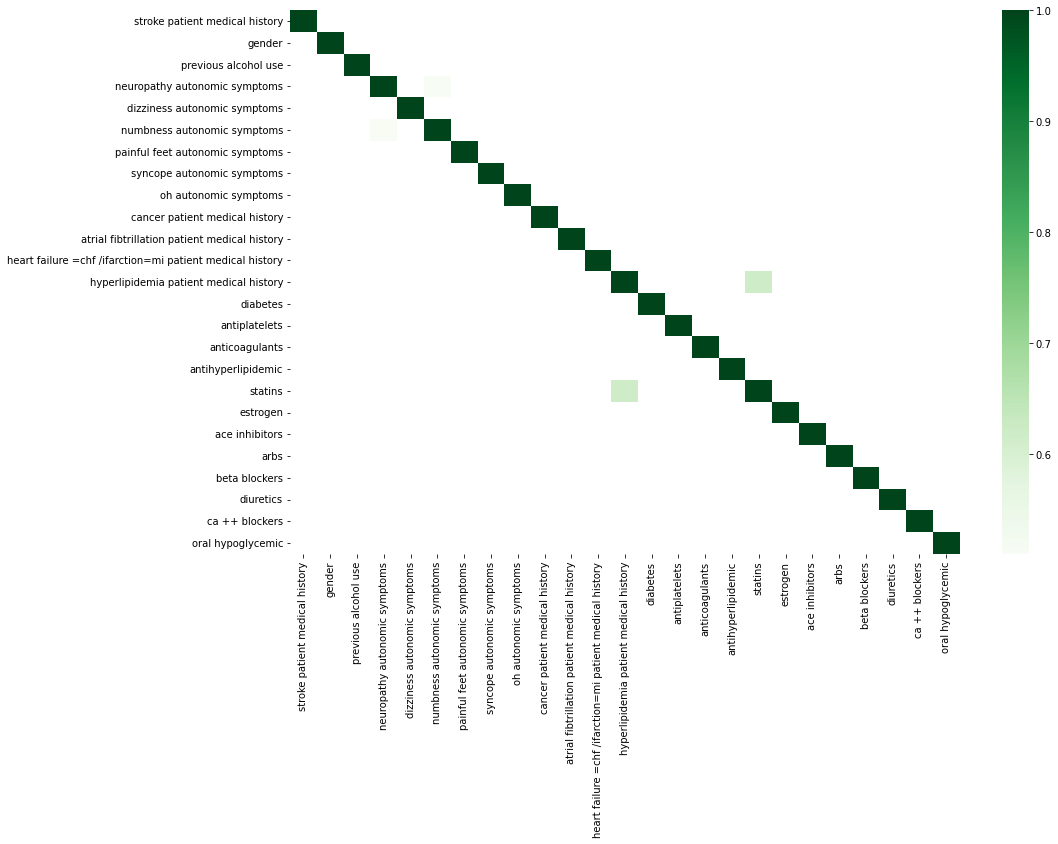

In [9]:
categorical_feature_stroke = df_stroke_v2.dtypes[df_stroke_v2.dtypes == object].index

stroke_cramers = profile_stroke_v2.description_set["correlations"]["cramers"].loc[categorical_feature_stroke, categorical_feature_stroke]
stroke_cramers_5 = stroke_cramers[abs(stroke_cramers) > 0.5] 
plt.figure(figsize=(15,10))
sns.heatmap(stroke_cramers_5, cmap="Greens")
plt.show()

We can see that antiplatelets and statins are correlated to past stroke event. This is expected since patients with a previous stroke usually take antiplatelets to prvent secondary stroke*. However, antiplatelets can be taken to prevent stroke. That will be interesting to see how the model integrate this feature.

In [10]:
res = stats.chi2_contingency(get_contengcy_matrix(df_stroke_v2["statins"], df_stroke_v2["hyperlipidemia patient medical history"] ))
print(f"hyperlipidemia\noddsratio: {res[0]} \npvalue: {res[1]}")

hyperlipidemia
oddsratio: 0.8981996726677578 
pvalue: 0.34326490414821964


The association is not significant which means it probably won't impact the SHAP analysis

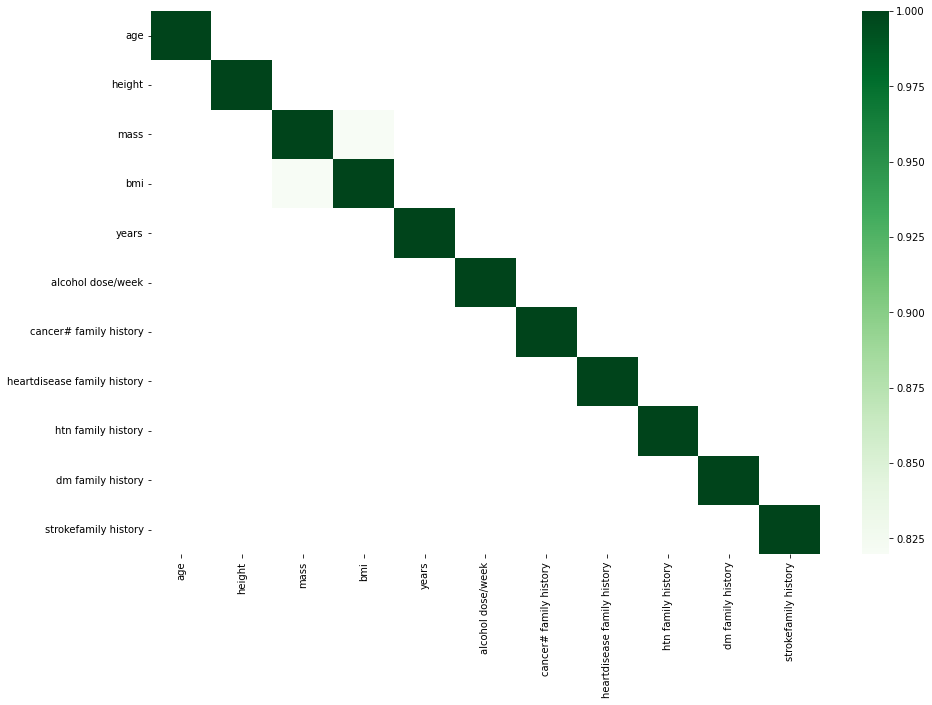

In [11]:
stroke_spearman = df_stroke_v2.corr("spearman")
stroke_spearman_5 = stroke_spearman[abs(stroke_spearman) > 0.5] 
plt.figure(figsize=(15,10))
sns.heatmap(stroke_spearman_5, cmap="Greens")
plt.show()

It is obvious than bmi and mass are correlated. Let's discard mass and height for modeling. 

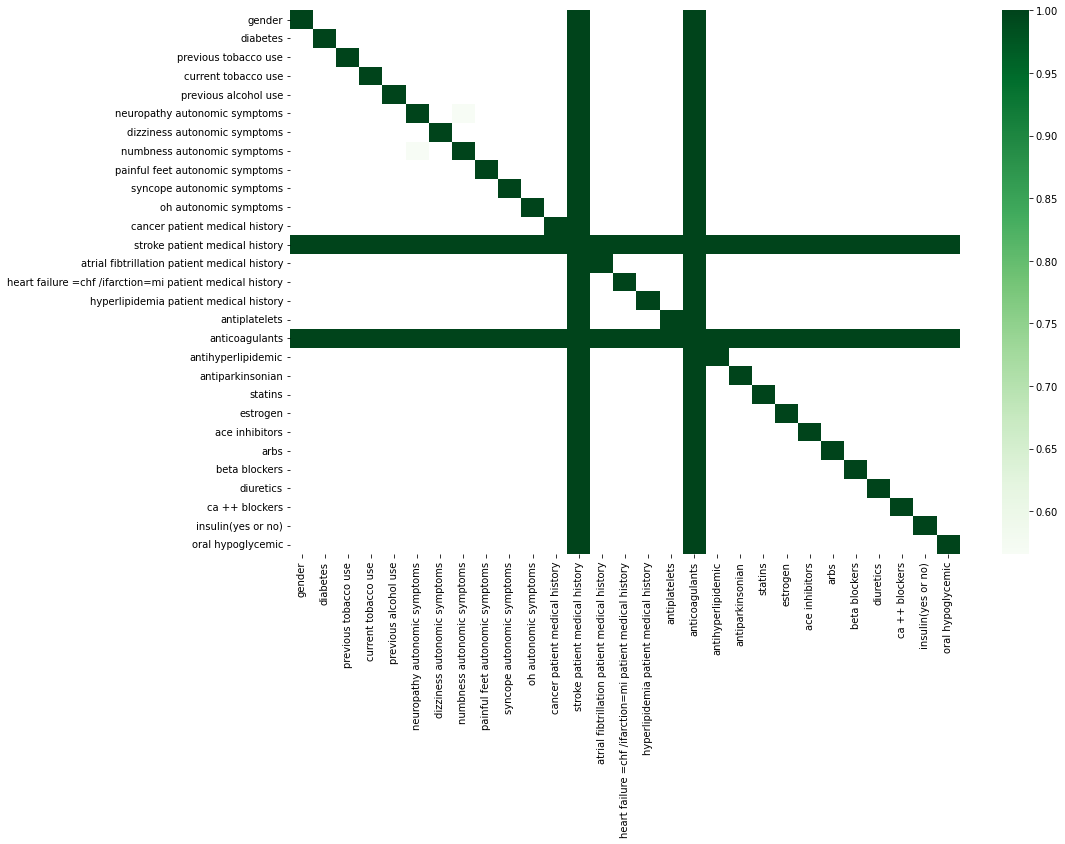

In [12]:
categorical_feature_perfusion = df_perfusion_v2.dtypes[df_perfusion_v2.dtypes == object].index

perfusion_cramers = profile_perfusion_v2.description_set["correlations"]["cramers"].loc[categorical_feature_perfusion, categorical_feature_perfusion]
perfusion_cramers_5 = perfusion_cramers[abs(perfusion_cramers) > 0.5] 
plt.figure(figsize=(15,10))
sns.heatmap(perfusion_cramers_5, cmap="Greens")
plt.show()

# Cleaning for modeling

We will drop correlated features that could perturb the SHAP analysis.
We want to analyze model's behaviour and understand why it could be biaised towards diabetic patiente, so we will drop diabetic patient. 

In [13]:
uncommon_features = set(df_perfusion_v2.columns).difference(df_stroke_v2.columns)
correlated_features = ["height", "mass"]

perfusion_modeling = df_perfusion_v2.drop(labels=uncommon_features, axis="columns")
perfusion_modeling.drop(labels=correlated_features, axis="columns", inplace=True)
perfusion_modeling.drop(labels="diabetes", axis="columns", inplace=True)

stroke_modeling = df_stroke_v2.drop(labels=correlated_features, axis="columns")
stroke_modeling.drop(stroke_modeling[stroke_modeling["diabetes"] == 'yes'].index, axis="index", inplace=True)
stroke_modeling.drop(labels="diabetes", axis="columns", inplace=True)

#stroke_modeling.to_csv("../data_cleaning/clean_data/stroke_modeling.csv", encoding='utf-8')
#perfusion_modeling.to_csv("../data_cleaning/clean_data/perfusion_modeling.csv", encoding='utf-8')


# Statistical Analysis on modeling datasets


In [14]:
profile_perfusion_modeling = ProfileReport(perfusion_modeling.reset_index(drop=True))
profile_stroke_modeling = ProfileReport(stroke_modeling.reset_index(drop=True))
#profile_perfusion_modeling.to_file(output_file='reports/profile_perfusion_modeling.html')
#profile_stroke_modeling.to_file(output_file='reports/profile_stroke_modeling.html')

In [15]:
profile_perfusion_modeling

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
profile_stroke_modeling

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Population consiste of 109 individuals (median age 67 years; IQR 62–72 years) in case of dataset_1 and 56 in case of dataset_2 (median age 66 years; IQR 58–73 years). Among dataset_1's patients, past stroke events is observed in 48 (42.2%) patients. In contrast, none of the patients in dataset_2 had a stroke history, and 50 (89.3%) are diabetic. 7 patients in dataset_2 were taking insulin, implying an advanced stage of T2DM.

# Age and Gender
Comparison of age and gender distribtion between the two datasets

In [17]:
print(stats.shapiro(perfusion_modeling["age"].to_numpy()))
print(stats.shapiro(stroke_modeling["age"].to_numpy()))

ShapiroResult(statistic=0.958642840385437, pvalue=0.052526406943798065)
ShapiroResult(statistic=0.9576600193977356, pvalue=0.0015874415403231978)


H0: the population is normally distributed
pvalue < 0.05

Stroke group doesn't follow a Normal distribution

In [18]:
stats.ttest_ind(perfusion_modeling["age"].to_numpy(), stroke_modeling["age"].to_numpy(), alternative="two-sided", equal_var=False)

Ttest_indResult(statistic=-0.927357766105065, pvalue=0.3559552771042779)

H0:  there is no significant difference between the means of the two groups.
p_value > 0.05 so no significant difference in age distribution

In [19]:
contengency_matrix_gender = [[(stroke_modeling["gender"] == 'male').sum(), (perfusion_modeling["gender"] == 'male').sum()], [(stroke_modeling["gender"] == 'female').sum(), (perfusion_modeling["gender"] == 'female').sum()]]
res = stats.chi2_contingency(contengency_matrix_gender)
print(f"gender\noddsratio: {res[0]} \npvalue: {res[1]}")

gender
oddsratio: 0.6083284087717657 
pvalue: 0.4354178888324125


H0: independence betwee two groups
p_value > 0.05 so no significant difference in gender distribution

In [20]:
print(stats.shapiro(stroke_modeling[stroke_modeling["stroke patient medical history"] == 'yes']["age"].to_numpy()))
print(stats.shapiro(stroke_modeling[stroke_modeling["stroke patient medical history"] == 'no']["age"].to_numpy()))

ShapiroResult(statistic=0.95332932472229, pvalue=0.06306920200586319)
ShapiroResult(statistic=0.9512441754341125, pvalue=0.014211548492312431)


In [21]:
stats.ttest_ind(stroke_modeling[stroke_modeling["stroke patient medical history"] == 'no']["age"].to_numpy(),
                   stroke_modeling[stroke_modeling["stroke patient medical history"] == 'yes']["age"].to_numpy(),
                   alternative="greater")

Ttest_indResult(statistic=3.4100135272720373, pvalue=0.00045859965333671873)

pvalue < 0.05 
There is an age difference between patient with and without stroke this dataset. The younger you are the more likely hou had a stroke 

# Obesity related features

Interestingly, there seems to be a difference of perfusion and stroke patients regarding bmi. Since wouldn't be surprinsing since we know obesity is a common comorbidity in T2DM.

In [22]:
print(stats.shapiro(perfusion_modeling["bmi"].to_numpy()))
print(stats.shapiro(stroke_modeling["bmi"].to_numpy()))

ShapiroResult(statistic=0.9242681860923767, pvalue=0.0017525386065244675)
ShapiroResult(statistic=0.9529813528060913, pvalue=0.000726566999219358)


p.values < 0.05 so both variables don't follow a Normal Law. Let's use a non parametric test to see if perfusion patients have a significantly higher bmi

In [23]:
stats.ttest_ind(perfusion_modeling["bmi"].to_numpy(), stroke_modeling["bmi"].to_numpy(), alternative="greater", equal_var=False)

Ttest_indResult(statistic=2.5578680485918066, pvalue=0.00606845578517536)

pvalue < 0.05 rejects the null hypothesis, perfusion patients have a higher bmi than stroke patients 

Let's also compare hyperlipidemia prevelance between the two groups since it's related to obesity.

In [24]:
#Let's see for hyperlipidemia

res = stats.chi2_contingency(get_contengcy_matrix(stroke_modeling["hyperlipidemia patient medical history"], perfusion_modeling["hyperlipidemia patient medical history"] ))
print(f"hyperlipidemia\noddsratio: {res[0]} \npvalue: {res[1]}")

res = stats.chi2_contingency(get_contengcy_matrix(stroke_modeling["antihyperlipidemic"], perfusion_modeling["antihyperlipidemic"] ))
print(f"\nantihyperlipidemia drug\noddsratio: {res[0]} \npvalue: {res[1]}")

res = stats.chi2_contingency(get_contengcy_matrix(stroke_modeling["statins"], perfusion_modeling["statins"] ))
print(f"\nstatins: \noddsratio: {res[0]} \npvalue: {res[1]}")

hyperlipidemia
oddsratio: 3.0721977170421297 
pvalue: 0.07964173737990134

antihyperlipidemia drug
oddsratio: 17.403502045095955 
pvalue: 3.022685407416329e-05

statins: 
oddsratio: 4.040993577717413 
pvalue: 0.04440766932310337


H0: independance of distribution of feature X between the 2 datasets

Hyperlipidemia & statins: pvalue > 0.05 so there's no difference between the two datasets regarding hyperlipidemia. However, people in the perfusion datasets are more prone to take antihyperlipidemia medication (pvalue < 0.05. 

# Lifestyle features - alcohol and smoking

In [25]:
print(stats.shapiro(perfusion_modeling["alcohol dose/week"].to_numpy()))
print(stats.shapiro(stroke_modeling["alcohol dose/week"].to_numpy()))

ShapiroResult(statistic=0.4526926279067993, pvalue=3.8712972714669003e-13)
ShapiroResult(statistic=0.43232083320617676, pvalue=1.2086705207981962e-18)


In [26]:
stats.ttest_ind(perfusion_modeling["alcohol dose/week"].to_numpy(), stroke_modeling["alcohol dose/week"].to_numpy(), alternative="two-sided")

Ttest_indResult(statistic=-0.42705922985859174, pvalue=0.6698997529842048)

In [27]:
print(stats.shapiro(perfusion_modeling["years"].to_numpy()))
print(stats.shapiro(stroke_modeling["years"].to_numpy()))

ShapiroResult(statistic=0.7479636669158936, pvalue=1.889381628927822e-08)
ShapiroResult(statistic=0.8142107725143433, pvalue=2.0996630822889273e-10)


In [28]:
stats.ttest_ind(perfusion_modeling["years"].to_numpy(), stroke_modeling["years"].to_numpy(), alternative="two-sided")

Ttest_indResult(statistic=-1.1441227943636012, pvalue=0.25425008894210976)

There is no significant variation of alcohol consumption nor smoking.

# Blood Pressure

ARBS: Angiotensin Receptor Blockers

ACE inhibitors: lower blood pressure by preventing the production of angiotensin II, a substance that narrows the blood vessels, while ARBs reduce the action of angiotensin II to prevent blood vessel constriction.

beta blockers: used to manage abnormal heart rhythms, and to protect the heart from a second heart attack (myocardial infarction) after a first heart attack (secondary prevention). They are also widely used to treat high blood pressure (hypertension), although they are no longer the first choice for initial treatment of most patients.

Diuretic:  the reduction in blood pressure is not due to decreased blood volume resulting from increased urine production, but occurs through other mechanisms and at lower doses than that required to produce diuresis

ca ++ blockers:   Calcium causes the heart and arteries to squeeze (contract) more strongly

In [29]:
htn_medication_perfusion = pd.DataFrame(perfusion_modeling.groupby(["arbs", 'ace inhibitors', 'beta blockers', "diuretics", "ca ++ blockers"]).size())
htn_medication_perfusion[0]/len(perfusion_modeling)


arbs  ace inhibitors  beta blockers  diuretics  ca ++ blockers
no    no              no             no         no                0.482143
                                                yes               0.035714
                                     yes        no                0.017857
                      yes            no         no                0.089286
                                     yes        no                0.017857
      yes             no             no         no                0.178571
                                     yes        yes               0.017857
                      yes            no         no                0.035714
                                                yes               0.017857
yes   no              no             no         no                0.035714
                                                yes               0.017857
                      yes            no         no                0.017857
                                     

In [30]:
htn_medication_stroke = pd.DataFrame(stroke_modeling.groupby(["arbs", 'ace inhibitors', 'beta blockers', "diuretics", "ca ++ blockers"]).size())
htn_medication_stroke[0]/len(stroke_modeling)

arbs  ace inhibitors  beta blockers  diuretics  ca ++ blockers
no    no              no             no         no                0.440367
                                                yes               0.009174
                                     yes        no                0.064220
                                                yes               0.036697
                      yes            no         no                0.082569
                                                yes               0.018349
                                     yes        no                0.009174
                                                yes               0.018349
      yes             no             no         no                0.100917
                                                yes               0.036697
                                     yes        no                0.018349
                                                yes               0.027523
                      yes            

Patients are taking multiple combination of medications.

In [31]:
print(htn_medication_stroke.shape)
print(htn_medication_perfusion.shape)

(20, 1)
(14, 1)


There are different combination of medications for hypertension. Need to investigate why and what it implies.

In [32]:
stroke_modeling[(stroke_modeling["oral hypoglycemic"] == 'yes')]

stroke patient medical history  age        bmi  gender  years  \
patient id                                                                 
s0210                                  no   72  27.120360  female   40.0   
s0239                                 yes   77  24.276183    male    0.0   

           previous alcohol use  alcohol dose/week  \
patient id                                           
s0210                        no                0.0   
s0239                        no                0.0   

           neuropathy autonomic symptoms dizziness autonomic symptoms  \
patient id                                                              
s0210                                yes                           no   
s0239                                 no                           no   

           numbness autonomic symptoms painful feet autonomic symptoms  \
patient id                                                               
s0210                               no                              no   
s0239                               no                              no   

           syncope autonomic symptoms oh autonomic symptoms  \
patient id                                                    
s0210                              no                    no   
s0239                              no                    no   

            cancer# family history  heartdisease family history  \
patient id                                                        
s0210                          2.0                          1.0   
s0239                          0.0                          0.0   

            htn family history  dm family history  strokefamily history  \
patient id                                                                
s0210                      0.0                1.0                   0.0   
s0239                      0.0                0.0                   0.0   

           cancer patient medical history  \
patient id                                  
s0210                                  no   
s0239                                  no   

           atrial fibtrillation patient medical history  \
patient id                                                
s0210                                                no   
s0239                                                no   

           heart failure =chf /ifarction=mi patient medical history  \
patient id                                                            
s0210                                                            no   
s0239                                                            no   

           hyperlipidemia patient medical history antiplatelets  \
patient id                                                        
s0210                                          no            no   
s0239                                         yes            no   

           anticoagulants antihyperlipidemic statins estrogen ace inhibitors  \
patient id                                                                     
s0210                  no                 no      no       no             no   
s0239                 yes                 no     yes       no            yes   

           arbs beta blockers diuretics ca ++ blockers oral hypoglycemic  
patient id                                                                
s0210        no            no       yes             no               yes  
s0239        no            no        no             no               yes

Two patients take oral hypoglycemic medication and one had a stroke.

# Disease history

We'll be tempted to use a two samples poisson test to compare family history diesease rates. We don't know how many generations the count covers. We'll see how the model handle this

In [33]:
disease_history = 'history'
list(stroke_modeling.loc[:, stroke_modeling.columns.str.contains(disease_history)].columns)

['stroke patient medical history',
 'cancer# family history',
 'heartdisease family history',
 'htn family history',
 'dm family history',
 'strokefamily history',
 'cancer patient medical history',
 'atrial fibtrillation patient medical history',
 'heart failure =chf /ifarction=mi patient medical history',
 'hyperlipidemia patient medical history']

In [34]:
contengency_matrix_dm_family = [[(stroke_modeling["dm family history"]).sum(), (perfusion_modeling["dm family history"]).sum()], [(stroke_modeling["dm family history"] == 0).sum(), (perfusion_modeling["dm family history"] == 0).sum()]]
stats.chi2_contingency(contengency_matrix_dm_family)

(30.062021260758943,
 4.184464845617262e-08,
 1,
 array([[70.60869565, 45.39130435],
        [55.39130435, 35.60869565]]))

# Insulin medication in perfusion dataset
7 patients in the perfusion datset are taking insulin. Usually patients taking insulin in T2DM are at advanced stage of the disease and therefore more at risk for CVDs.